Coding the quantum Fourier Algorithm

In [2]:
!pip install qiskit ipywidgets
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=21027c06da7a2e34dd59da9fd65bbbf0b2cc70111ce2c9fbd396fb52671e9d70
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [3]:
import numpy as np
numpy_result=np.fft.fft([4,3,2,1]) #samples are given in brackets
print(numpy_result)

[10.+0.j  2.-2.j  2.+0.j  2.+2.j]


In [4]:
#Now using scipy here for doing the same task:
from scipy.fft import fft
scipy_result=fft([4,3,2,1])
print(scipy_result)

[10.-0.j  2.-2.j  2.-0.j  2.+2.j]


In [5]:
#Now doing it with qiskit:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

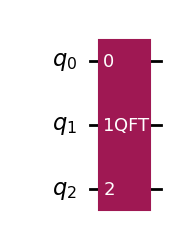

In [6]:
#We need to show the decomposed circuit, since transpile update was recently done :
qc=QuantumCircuit(3) # # qubits, could estimate 8 samples in total for us
qc.append(QFT(3), range(3)) #QFT(3) could the argument here be less than 3 as well, specifying the range for mapping purpose, it could be the other way as well
qc.draw('mpl')

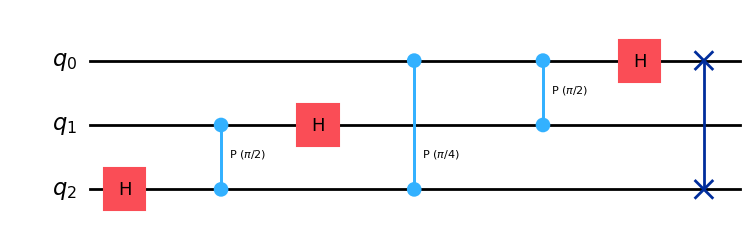

In [7]:
qc.decompose().decompose().draw('mpl') #decompose twice to get what we want

 Here is a problem with this circuit, our circuit has first Hadamard on q2, due to labeling complications of qubits done by developer and recent updates of it, for qubits to match the computer science consideration, the inverse of fourier transform code gives you the fourier transform, and the fourier transform code actually gives you the inverse fourier transform. Here's the way to do it right as given below:

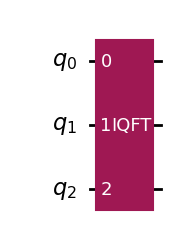

In [8]:
qc=QuantumCircuit(3) # # qubits, could estimate 8 samples in total for us
qc.append(QFT(num_qubits=3, inverse=True,), range(3))
qc.draw('mpl')

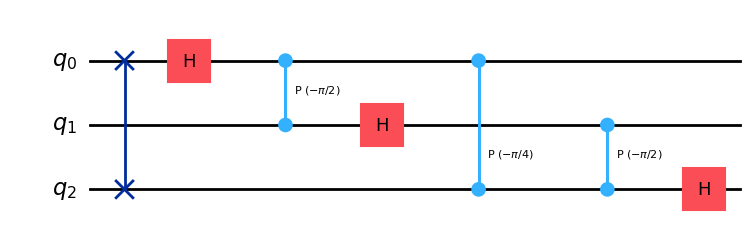

In [9]:
qc.decompose().decompose().draw('mpl')

Again it could be obsesrved that the single qubit gates are favored, also the inverse is applied. at the begining which is no problem here. So now this circuit could do a quantum forier transform for us( still for that, we need to use inverse, until qiskit developer fix this issue on future updates)

In [10]:
#Now using the old sample we had, first need to find state vectors:
from qiskit.quantum_info import Statevector
#Now define an array of samples to implement modifications on it easier
array=[4,3,2,1]
#number of samples= 2^(number of qubits) , or log2(number of samples)=number of qubits , if having 6 samples, the number of qubits needed is 3, adding samples by averaging or other techniques
num_qubits=int(np.ceil(np.log2(len(array)))) #by finding the length of array, we figure number of samples then take log2 of it, then using numpy ceiling

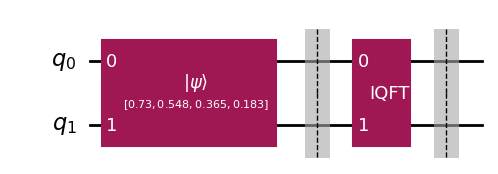

In [11]:
qc=QuantumCircuit(num_qubits)
#how to give all 4 samples simultaneously to it? using initialize as an encoding technique, first finding the norm
state_norm=np.linalg.norm(array)
qc.initialize(array, range(num_qubits),normalize=True) #encode the sample I have, map them on qubits I have in a consecutive order, also normalize it
qc.barrier()
#Now check what state the encoded information will give me?
state1=Statevector.from_instruction(qc) # in practice if we wanna do this, we need to do quantum tomography, which is done here easily
#By having state 1, we have the statevector of our quantum circuit, now we implement quantum fourier transform:
qc.append(QFT(num_qubits, inverse=True), range(num_qubits))
qc.barrier()
#finding state of quantum circuit after implementing quantum fourier transform:
state2=Statevector.from_instruction(qc)

qc.draw('mpl')

So it first encodes, then implement fourier transform, to see inside the box, using decompose:

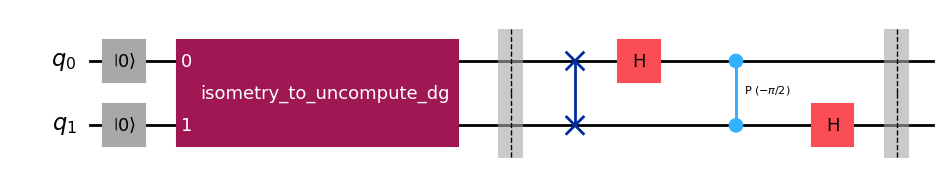

In [12]:
qc.decompose().decompose().draw('mpl')

for decoding, using the inverse of " isometry_to_uncompute_dg " which is reversable, would take care of decoding for us.However, because of reverse in the begining it would be complicated to decode, so beter to do the decode manually

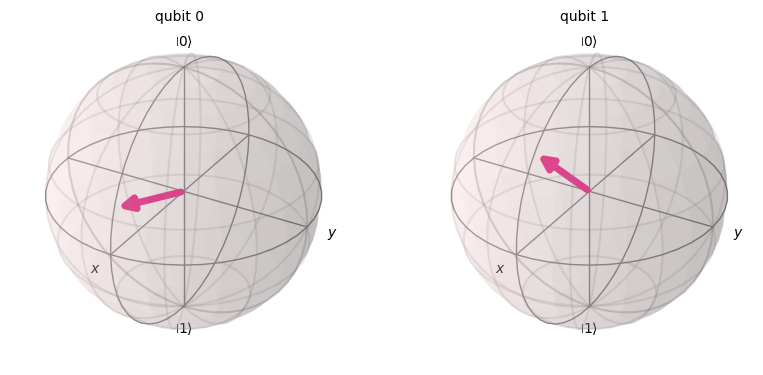

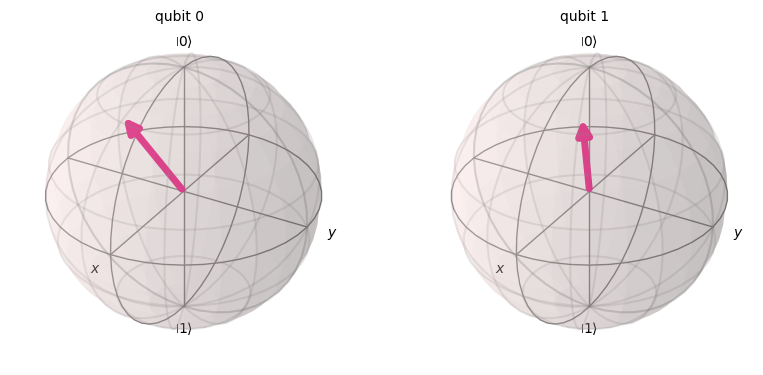

In [14]:
display(state1.draw('bloch')) #getting bloch sphere only when dealing with states, rather than circuits
display(state2.draw('bloch'))

The representation of all 4 samples encoded here altogether gives the first two bloch spheres we have above, then the fourier transform of them is also given in the next two bloch spheres

In [15]:
amplitudes=state2.data
print(f"Amplitude:{amplitudes}")

Amplitude:[0.91287093+0.j         0.18257419-0.18257419j 0.18257419+0.j
 0.18257419+0.18257419j]


THe reason for us not to get the expected answers is that we have not decode the encoded information yet, so the way to. do it is:

In [16]:
fft_result=amplitudes* state_norm *np.sqrt(len(array))
print(f"qiskit QFT results:{fft_result}")


qiskit QFT results:[10.+0.j  2.-2.j  2.+0.j  2.+2.j]


Now comparing with numpy and scipy that are both using the logN ordering for finding  fourier transform results, dispite what QFT does.

In [17]:
print(f"nnumpy FFT results:{numpy_result}")
print(f"scipy FFT results:{scipy_result}")

nnumpy FFT results:[10.+0.j  2.-2.j  2.+0.j  2.+2.j]
scipy FFT results:[10.-0.j  2.-2.j  2.-0.j  2.+2.j]


qiskit QFT result is exactly the same as numpy FFT result

Also, the QFT code by default gives us the inverse fourier transform, since by default it has inverse=False, yet we have to be careful about the encoded information, it is useful for Shor's Algorithm

#Period Finding Algorithm

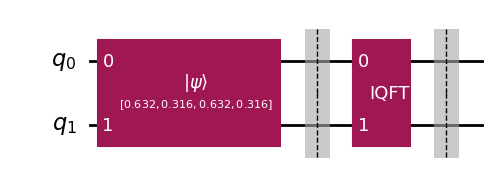

In [20]:
#Now using the old sample we had, first need to find state vectors:
from qiskit.quantum_info import Statevector
#Now define an array of samples to implement modifications on it easier
array=[2,1,2,1]
#number of samples= 2^(number of qubits) , or log2(number of samples)=number of qubits , if having 6 samples, the number of qubits needed is 3, adding samples by averaging or other techniques
num_qubits=int(np.ceil(np.log2(len(array)))) #by finding the length of array, we figure number of samples then take log2 of it, then using numpy ceiling
qc=QuantumCircuit(num_qubits)
#how to give all 4 samples simultaneously to it? using initialize as an encoding technique, first finding the norm
state_norm=np.linalg.norm(array)
qc.initialize(array, range(num_qubits),normalize=True) #encode the sample I have, map them on qubits I have in a consecutive order, also normalize it
qc.barrier()
#Now check what state the encoded information will give me?
state1=Statevector.from_instruction(qc) # in practice if we wanna do this, we need to do quantum tomography, which is done here easily
#By having state1, we have the statevector of our quantum circuit, now we implement quantum fourier transform:
qc.append(QFT(num_qubits, inverse=True), range(num_qubits))
qc.barrier()
#finding state of quantum circuit after implementing quantum fourier transform:
state2=Statevector.from_instruction(qc)

qc.draw('mpl')


In [21]:
numpy_result=np.fft.ifft(array) #The given function is not periodic and the point about FFT is that by providin a periodic input, given the periodds, it'll give zero

print(numpy_result)

[1.5+0.j 0. +0.j 0.5+0.j 0. +0.j]


the values aren't important, however givn the number of zeroes we find here, we will have period

In [23]:
array=[2,1,2,1,2,1,2,1]
numpy_result=np.fft.fft(array)
print(numpy_result)

[12.+0.j  0.+0.j  0.+0.j  0.+0.j  4.+0.j  0.+0.j  0.+0.j  0.+0.j]


In [29]:
#Now using the old sample we had, first need to find state vectors:
from qiskit.quantum_info import Statevector
#Now define an array of samples to implement modifications on it easier
array=[2,1,2,1,2,1,2,1]
#number of samples= 2^(number of qubits) , or log2(number of samples)=number of qubits , if having 6 samples, the number of qubits needed is 3, adding samples by averaging or other techniques
num_qubits=int(np.ceil(np.log2(len(array)))) #by finding the length of array, we figure number of samples then take log2 of it, then using numpy ceiling
qc=QuantumCircuit(num_qubits)
#how to give all 4 samples simultaneously to it? using initialize as an encoding technique, first finding the norm
state_norm=np.linalg.norm(array)
qc.initialize(array, range(num_qubits),normalize=True) #encode the sample I have, map them on qubits I have in a consecutive order, also normalize it
qc.barrier()
#Now check what state the encoded information will give me?
state1=Statevector.from_instruction(qc) # in practice if we wanna do this, we need to do quantum tomography, which is done here easily
#BYhaving state1, we have the statevector of our quantum circuit, now we implement quantum fourier transform:
qc.append(QFT(num_qubits, inverse=True), range(num_qubits))
qc.barrier()
#finding state of quantum circuit after implementing quantum fourier transform:
state2=Statevector.from_instruction(qc)
amplitudes=state2.data
ft_result=amplitudes* state_norm *np.sqrt(len(array))
threshold=1e-10 #setting threshold to show 1 digit after decimal point only
fft_result_cleaned=np.where(np.abs(ft_result) > threshold, fft_result,0)
print(f"qiskit QFT results:{fft_result}")
print(f"qiskit QFT results:{fft_result_cleaned}")
print(numpy_result)



qiskit QFT results:[ 1.20000000e+01+0.00000000e+00j -7.15532459e-17+1.22149031e-16j
 -1.40697895e-16+7.03489476e-17j -7.15532459e-17-2.09574605e-17j
  4.00000000e+00+0.00000000e+00j -7.15532459e-17+2.09574605e-17j
 -1.40697895e-16-7.03489476e-17j -7.15532459e-17-1.22149031e-16j]
qiskit QFT results:[12.+0.j  0.+0.j  0.+0.j  0.+0.j  4.+0.j  0.+0.j  0.+0.j  0.+0.j]
[12.+0.j  0.+0.j  0.+0.j  0.+0.j  4.+0.j  0.+0.j  0.+0.j  0.+0.j]


the result of numpy for periodic case, is same as what we obtained using the QFT Algorithm